In [9]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from datetime import datetime
import time
import re
from ipaddress import ip_address
from urllib.parse import urlparse
import json
import isodate
from dateutil import parser
from dateutil import tz
from pyspark.sql.types import StructField, StructType, StringType
from pyspark.sql import Row
from pyspark.sql import functions as pyspark_function
from urllib.request import urlopen
import subprocess
import os.path
from os import path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import mktime


In [2]:
import findspark
findspark.init()
import pyspark
import random
from pyspark.sql.functions import *
import pyspark.sql.functions as f
import pyspark.sql.functions as pyf
import numpy as np
import pandas 
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext


        
spark = SparkSession \
        .builder \
        .appName("Test Spark") \
        .config("spark.jars", "/opt/postgresql-42.4.0.jar") \
        .config("spark.num.executors"," 16")  \
        .config("spark.executor.cores", "8") \
        .config("spark.executor.memory", "20g") \
        .config("spark.scheduler.mode", "FAIR") \
        .config("spark.sql.autoBroadcastJoinThreshold", -1) \
        .master("spark://131.225.58.251:7077") \
        .getOrCreate() \



#spark.conf.set("spark.executor.memory", "20g")
#spark.conf.set("spark.executor.cores", "8")

22/06/29 14:23:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/06/29 14:23:39 WARN FairSchedulableBuilder: Fair Scheduler configuration file not found so jobs will be scheduled in FIFO order. To use fair scheduling, configure pools in fairscheduler.xml or set spark.scheduler.allocation.file to a file that contains the configuration.


In [4]:
df = spark.read \
     .format("jdbc") \
     .option("url", "jdbc:postgresql://fndca5b:5432/billing") \
     .option("dbtable", "(select *,  split_part(storageclass, '.', 1) as vo from storageinfo where datestamp between '2022-06-01 00:00:00' and now()) as foo") \
     .option("user", "enstore_reader") \
     .option("driver", "org.postgresql.Driver") \
     .option("numPartitions", "16") \
     .option("partitionColumn", "datestamp") \
     .option("lowerBound", "2022-06-01 00:00:00") \
     .option("upperBound", "2022-06-26 23:59:59") \
     .option("fetchsize", 1000000) \
     .load()

df.printSchema()

root
 |-- queuedtime: long (nullable = true)
 |-- fullsize: long (nullable = true)
 |-- storageclass: string (nullable = true)
 |-- connectiontime: long (nullable = true)
 |-- action: string (nullable = true)
 |-- cellname: string (nullable = true)
 |-- datestamp: timestamp (nullable = true)
 |-- errorcode: integer (nullable = true)
 |-- errormessage: string (nullable = true)
 |-- pnfsid: string (nullable = true)
 |-- transaction: string (nullable = true)
 |-- vo: string (nullable = true)



In [5]:
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

,Column Name,Data type
0,queuedtime,bigint
1,fullsize,bigint
2,storageclass,string
3,connectiontime,bigint
4,action,string
5,cellname,string
6,datestamp,timestamp
7,errorcode,int
8,errormessage,string
9,pnfsid,string


In [10]:
t0 = time.time()
print("Number of entries is    =====> ", df.count(), " Time to execute ", time.time()-t0)

Number of entries is    =====>  13118753  Time to execute  67.26329398155212


In [11]:
df.createOrReplaceTempView("billing")
df.cache()
print("Number of entries again =====> ", df.count(), " Time to execute ", time.time()-t0)

DataFrame[queuedtime: bigint, fullsize: bigint, storageclass: string, connectiontime: bigint, action: string, cellname: string, datestamp: timestamp, errorcode: int, errormessage: string, pnfsid: string, transaction: string, vo: string]

Number of entries again =====>  13119034  Time to execute  143.11736750602722


In [97]:
# df_vo = spark.sql("SELECT DISTINCT(vo),COUNT(vo) AS number_of_restores FROM billing WHERE action='restore' group by vo order by number_of_restores  desc ")
# df_vo.show()

+--------+------------------+
|      vo|number_of_restores|
+--------+------------------+
|  uboone|           2915928|
| minerva|           2886461|
|     GM2|            359564|
|    nova|            228477|
|    none|            163906|
|    dune|            146812|
| netflow|             93211|
|  icarus|             26173|
|  lariat|             24110|
|    mu2e|             18065|
|    e906|              6587|
|darkside|               864|
|    lqcd|               190|
|   annie|                 7|
| accelai|                 3|
|    sbnd|                 1|
|    test|                 1|
+--------+------------------+



In [117]:
df_vo = spark.sql("SELECT DISTINCT(vo),COUNT(vo) AS number_of_restores FROM billing WHERE action='restore' and errorcode = 0 group by vo order by number_of_restores  desc ")
df_vo.show()

+--------+------------------+
|      vo|number_of_restores|
+--------+------------------+
|  uboone|           2877902|
| minerva|           1354754|
|     GM2|            342448|
|    nova|            227416|
|    dune|            146313|
|    none|            132607|
|  icarus|             25453|
|  lariat|             23997|
|    mu2e|             17845|
|    e906|              6587|
|darkside|               864|
|    lqcd|               187|
|   annie|                 7|
| accelai|                 3|
|    sbnd|                 1|
|    test|                 1|
+--------+------------------+



In [118]:
# df_vo2 = spark.sql("SELECT DISTINCT(vo),COUNT(vo) AS number_of_restores FROM billing WHERE action='restore' and errorcode != 0 group by vo order by number_of_restores  desc ")
# df_vo2.show()

+-------+------------------+
|     vo|number_of_restores|
+-------+------------------+
|minerva|           1531707|
|netflow|             93211|
| uboone|             38026|
|   none|             31299|
|    GM2|             17116|
|   nova|              1061|
| icarus|               720|
|   dune|               499|
|   mu2e|               220|
| lariat|               113|
|   lqcd|                 3|
+-------+------------------+



In [119]:
#can you print a few lines of errormessage for vo = 'minerva' errorcode !=0
# df_vo2 = spark.sql("SELECT errormessage FROM billing WHERE vo = 'minerva' and action='restore' and errorcode != 0 group by errormessage ")
# df_vo2.show()

In [120]:
df_vo.count()

16

In [82]:
#df_time= df.withColumn("time", to_date(df.datestamp))
#df_time.select('time').show(100)

In [61]:
# restore_data = "restore"
# sql_query = f"select action from billing where action='{restore_data}' order by action"
# write_per_restore = spark.sql(sql_query)
# write_per_restore.show()

In [27]:
write_per_restore = spark.sql("select DISTINCT(action) from billing where action='restore'")
write_per_restore.show()

+-------+
| action|
+-------+
|restore|
+-------+



In [54]:
# pools_array = df_vo.rdd.map(lambda row: row[0]).collect()
# size_array  = write_per_restore.rdd.map(lambda row: row[1]).collect()

In [56]:
#df_vo.join(write_per_restore, "outer")

In [121]:
unioned_df = write_per_restore.join(df_vo)
unioned_df.show(100)

+-------+--------+------------------+
| action|      vo|number_of_restores|
+-------+--------+------------------+
|restore|  uboone|           2877902|
|restore| minerva|           1354754|
|restore|     GM2|            342448|
|restore|    nova|            227416|
|restore|    dune|            146313|
|restore|    none|            132607|
|restore|  icarus|             25453|
|restore|  lariat|             23997|
|restore|    mu2e|             17845|
|restore|    e906|              6587|
|restore|darkside|               864|
|restore|    lqcd|               187|
|restore|   annie|                 7|
|restore| accelai|                 3|
|restore|    test|                 1|
|restore|    sbnd|                 1|
+-------+--------+------------------+



In [122]:
d1=unioned_df.toPandas()
print(d1)

     action        vo  number_of_restores
0   restore      nova              227416
1   restore   minerva             1354754
2   restore      dune              146313
3   restore      none              132607
4   restore    uboone             2877902
5   restore      lqcd                 187
6   restore       GM2              342448
7   restore      mu2e               17845
8   restore     annie                   7
9   restore    lariat               23997
10  restore  darkside                 864
11  restore    icarus               25453
12  restore      sbnd                   1
13  restore      e906                6587
14  restore      test                   1
15  restore   accelai                   3


In [50]:
#d2= d1.groupby(['number_of_restores']).sum()

In [51]:
#print(d2)

In [123]:
d1=d1.sort_values(by=['number_of_restores'], ascending=False)

In [124]:
print(d1)

     action        vo  number_of_restores
4   restore    uboone             2877902
1   restore   minerva             1354754
6   restore       GM2              342448
0   restore      nova              227416
2   restore      dune              146313
3   restore      none              132607
11  restore    icarus               25453
9   restore    lariat               23997
7   restore      mu2e               17845
13  restore      e906                6587
10  restore  darkside                 864
5   restore      lqcd                 187
8   restore     annie                   7
15  restore   accelai                   3
12  restore      sbnd                   1
14  restore      test                   1


<AxesSubplot:xlabel='vo'>

Text(0.5, 0, 'vo')

Text(0, 0.5, 'number_of_restores')

/tmp/ipykernel_131317/210314548.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fontsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('name.png' ,fontsize=24)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'uboone'),
  Text(1, 0, 'minerva'),
  Text(2, 0, 'GM2'),
  Text(3, 0, 'nova'),
  Text(4, 0, 'dune'),
  Text(5, 0, 'none'),
  Text(6, 0, 'icarus'),
  Text(7, 0, 'lariat'),
  Text(8, 0, 'mu2e'),
  Text(9, 0, 'e906'),
  Text(10, 0, 'darkside'),
  Text(11, 0, 'lqcd'),
  Text(12, 0, 'annie'),
  Text(13, 0, 'accelai'),
  Text(14, 0, 'sbnd'),
  Text(15, 0, 'test')])

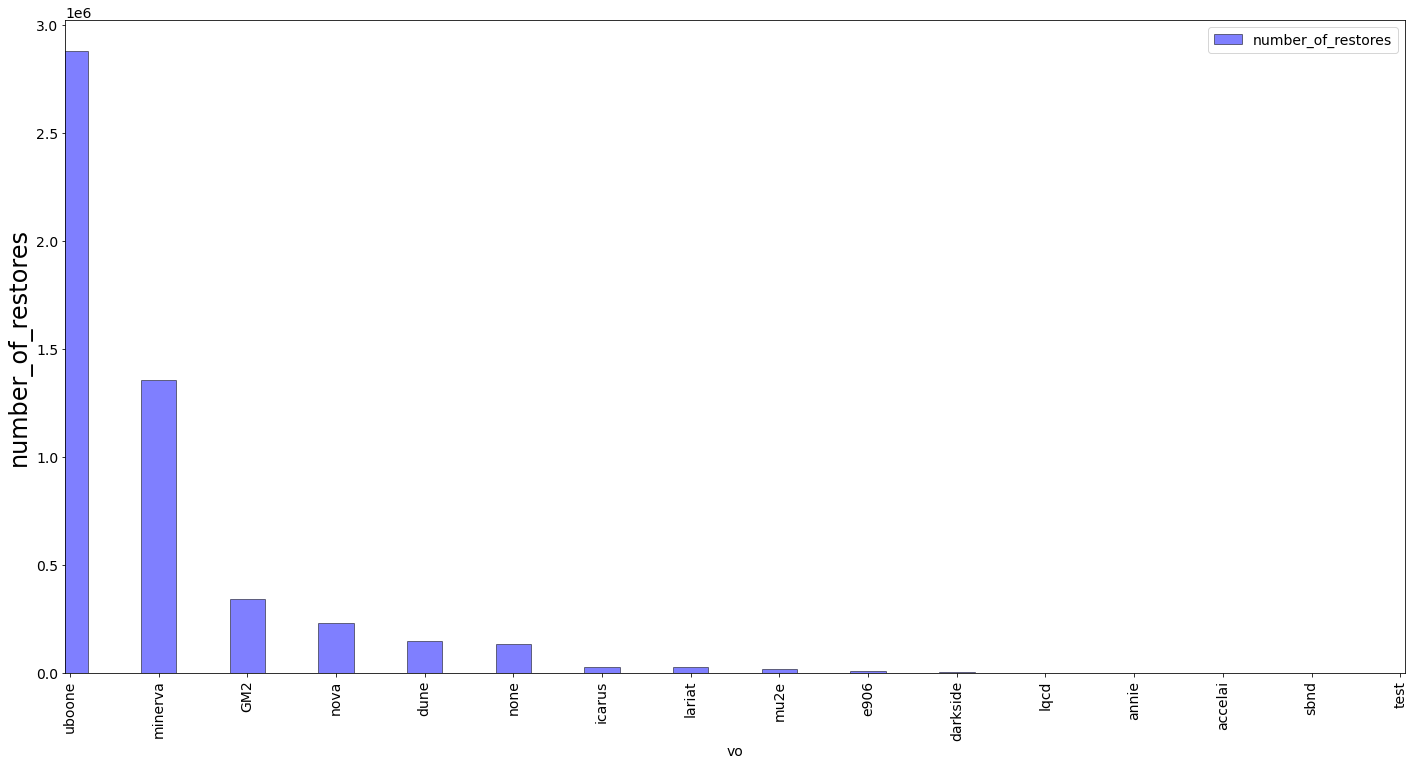

In [127]:
#plt.bar(d1, color='blue',edgecolor = 'black', alpha=0.5 ,figsize=(24,12), align='edge', width=-0.4)
d1.plot.bar(x='vo', y='number_of_restores' , color='blue',edgecolor = 'black', alpha=0.5 ,figsize=(24,12),align='center', width=-0.4)
plt.xlabel("vo")
plt.ylabel("number_of_restores" ,fontsize=24)
plt.savefig('name.png' ,fontsize=24)
plt.rcParams.update({'font.size': 14})
plt.xticks(rotation=90)
plt.show()
#plt.ylabel("No.of students")
# plt.ylabel('number_of_restores',fontsize=24)
# plt.xlabel('vo',fontsize=24)
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
#d1.plot.bar()

In [ ]:
# df1=df.where(df.action=='restore').select(['action','vo','date'])
# df1.show(100)
# print("Number of entries is ", df1.count())
# df1.groupBy('vo').count().select('vo', f.col('count').alias('count')).show()
# df2=df1.withColumn('count', df1['vo'].groupBy('vo').count().select('vo', f.col('count').alias('count')))
# from pyspark.sql import Window
# w = Window.partitionBy('action')
# df.select('action','vo','date', f.count('action').over(w).alias('count')).sort('action','vo','date').show(100)
# df1=df.where(df.action=='restore').select(['action','vo','date'])
# df1.show(100)
# spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
# spark.conf.set(
#     "spark.sql.execution.arrow.pyspark.fallback.enabled", "true")
# pd_df = df1.toPandas()
# print(pd_df)
# pd_df.groupby(['date']).sum('action'.count)
